In [1]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+1


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

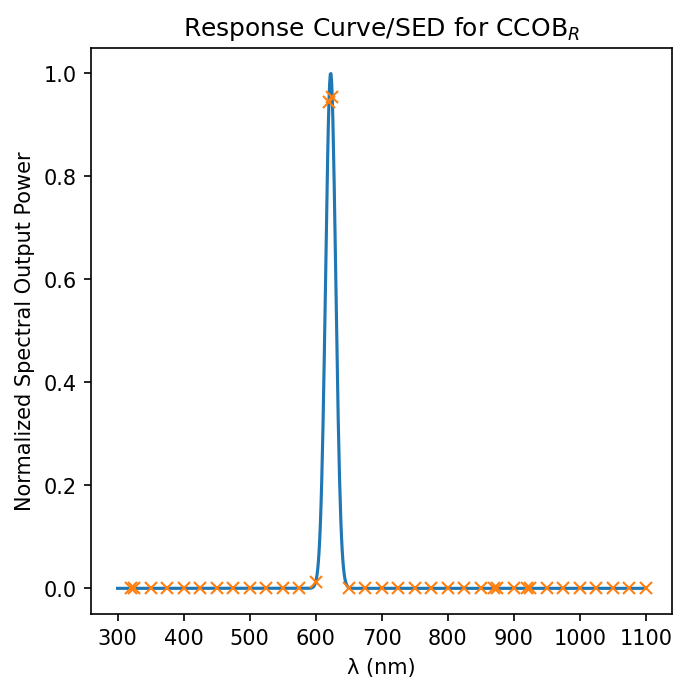

In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)



# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)


# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)    
# plots 'x's
pylab.plot(wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

In [3]:
superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias


num_ch  = 16    
img_list = []
MEDIAN = None

for ch in range(num_ch):
    arr = []       
    for i, aqeflatpath in enumerate(qeflatpath):
        aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    
        img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array
        
        MEDIAN = numpy.median(img)
        img = img/MEDIAN     # this will normalize your image

        arr.append(img*weights[i])
        
    img = numpy.sum(arr,axis=0)/numpy.sum(weights) 
    std = mad_std(img)
    
    img_list.append(img)   

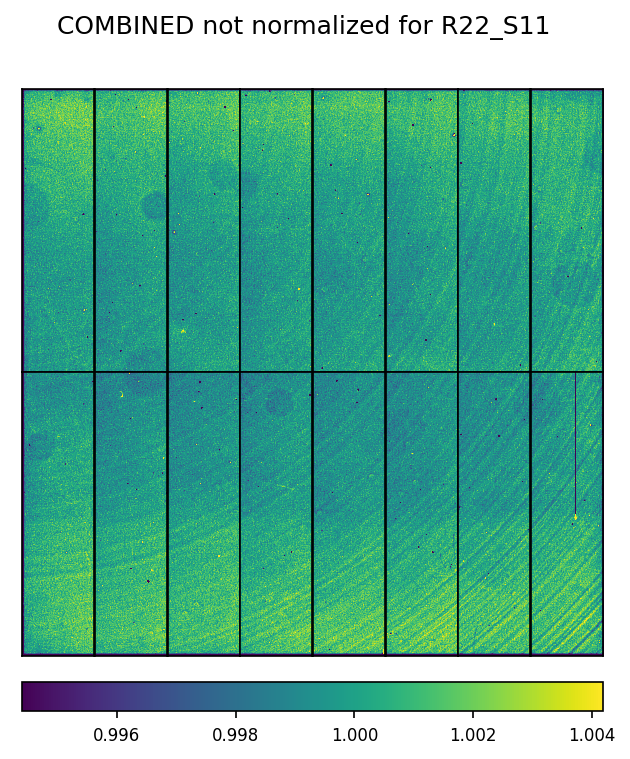

In [4]:
plotonesensor_ITL(img_list, "COMBINED not normalized for R22_S11")

In [5]:
red_arr = [None] * num_ch
normedimg_arr = [None] * num_ch
MEDIAN = None

fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"     
ccob_red = get_ccd_from_id(None, fname, [])

for ch in range(num_ch):    
    red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]    # QE data array
    MEDIAN = numpy.median(red)                                        # median (not mean, avoiding outliers) of QE data array for CCOBred, will normalize COMBINED with this
    normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
    normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
    red_arr[ch] = red        
    

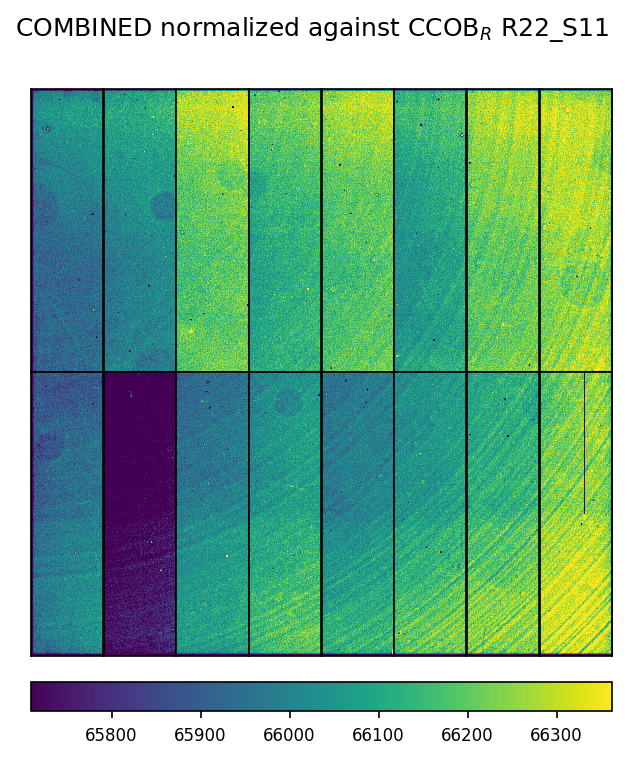

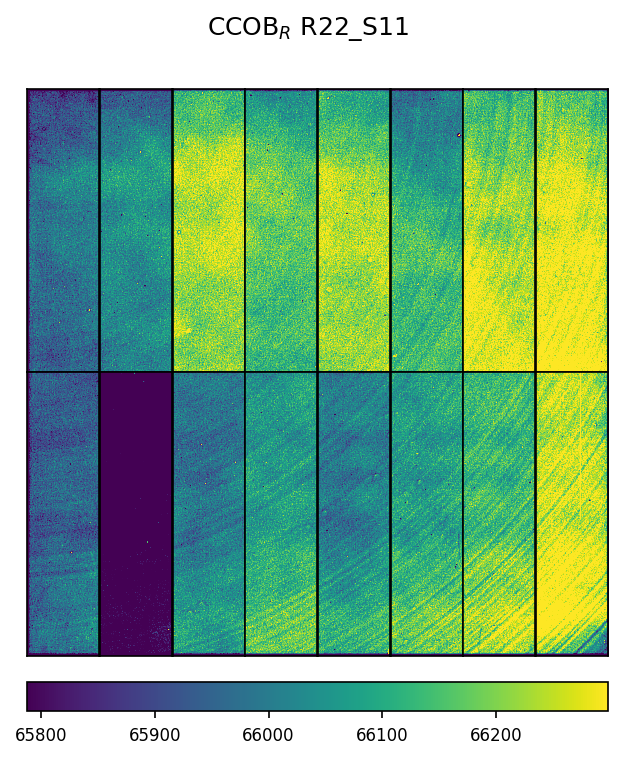

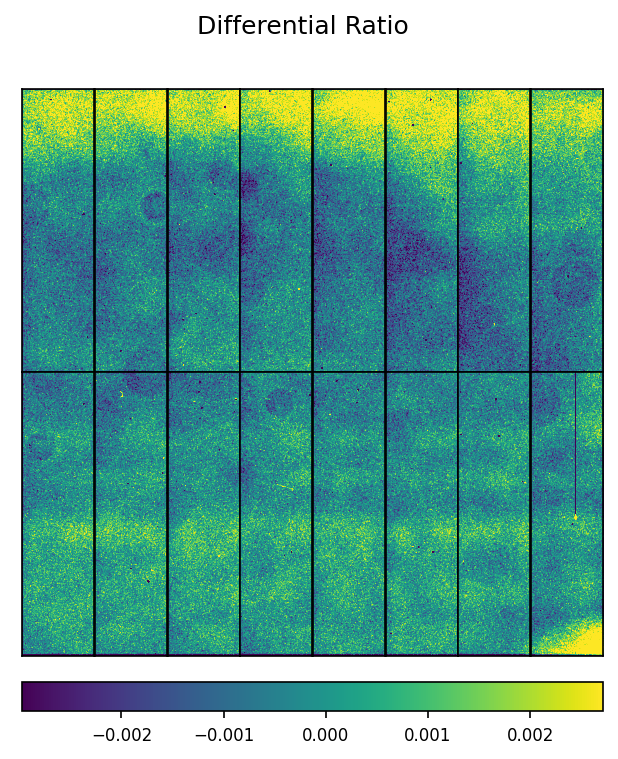

In [6]:
# plot normalized, COMBINED flat
plotonesensor_ITL(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ R22_S11')

# plot CCOBred flat
plotonesensor_ITL(red_arr, 'CCOB$_{R}$ R22_S11')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
plotonesensor_ITL(diff_arr, 'Differential Ratio')

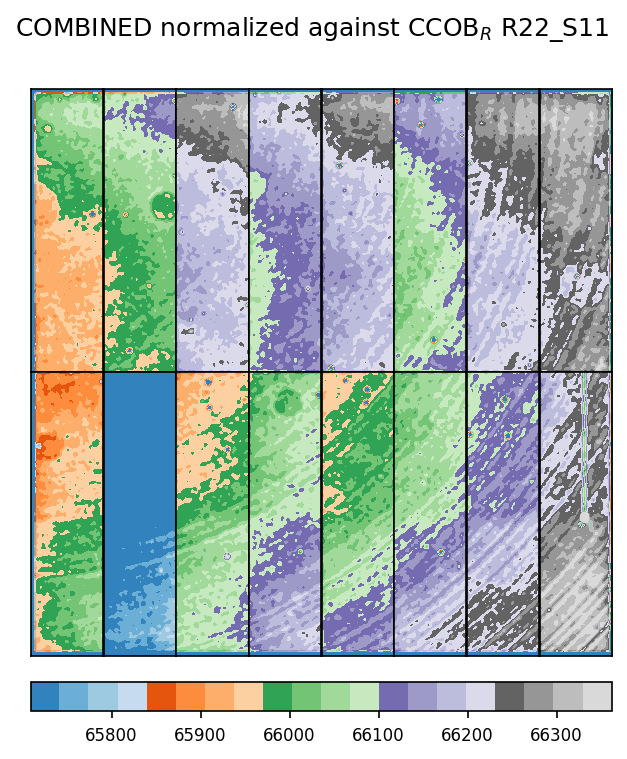

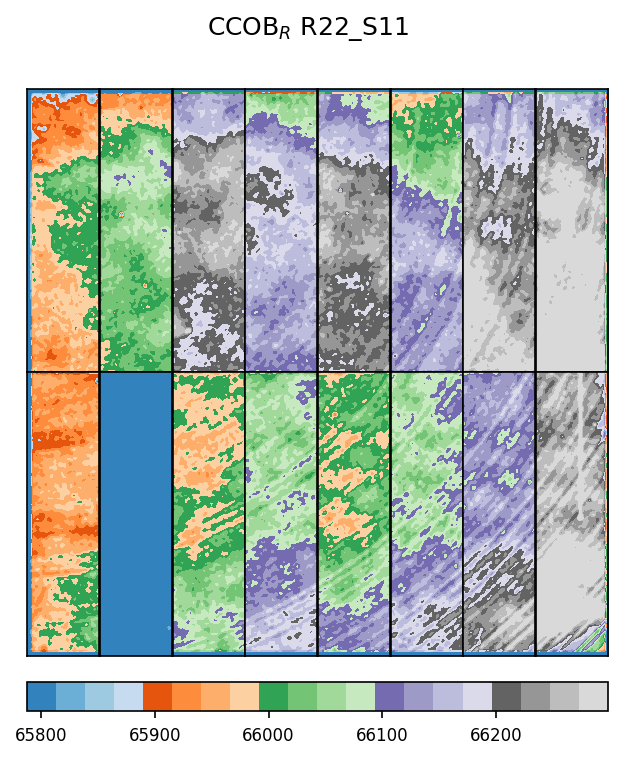

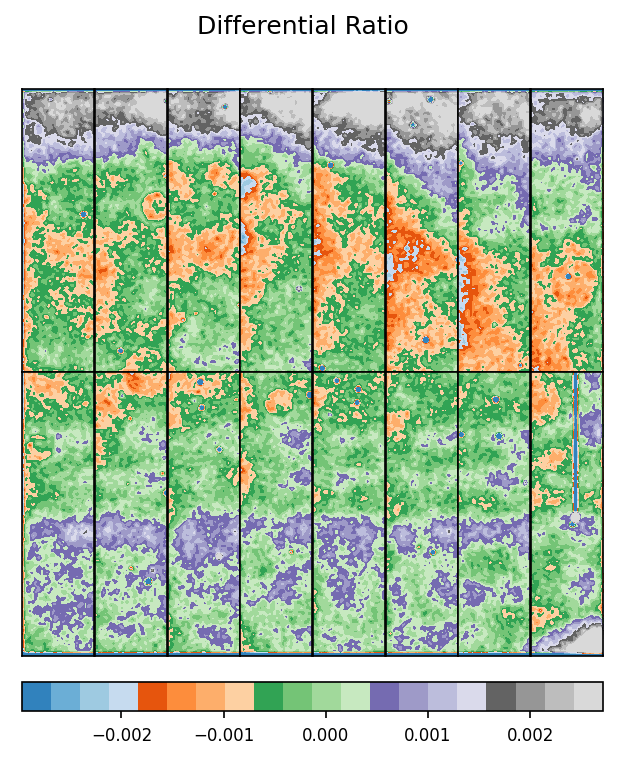

In [7]:
# plot normalized, COMBINED flat
plotonesensor_ITL_smooth(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ R22_S11')

# plot CCOBred flat
plotonesensor_ITL_smooth(red_arr, 'CCOB$_{R}$ R22_S11')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
    
plotonesensor_ITL_smooth(diff_arr, 'Differential Ratio')

In [8]:
xmin= -0.025
xmax= 0.025
nbins= 101    # fixing fencepost issue, last bin doesn't include that right edge
bins= np.linspace(xmin, xmax, nbins)

width = (xmax-xmin)/ (nbins-1)

In [9]:
bins

array([-0.025 , -0.0245, -0.024 , -0.0235, -0.023 , -0.0225, -0.022 ,
       -0.0215, -0.021 , -0.0205, -0.02  , -0.0195, -0.019 , -0.0185,
       -0.018 , -0.0175, -0.017 , -0.0165, -0.016 , -0.0155, -0.015 ,
       -0.0145, -0.014 , -0.0135, -0.013 , -0.0125, -0.012 , -0.0115,
       -0.011 , -0.0105, -0.01  , -0.0095, -0.009 , -0.0085, -0.008 ,
       -0.0075, -0.007 , -0.0065, -0.006 , -0.0055, -0.005 , -0.0045,
       -0.004 , -0.0035, -0.003 , -0.0025, -0.002 , -0.0015, -0.001 ,
       -0.0005,  0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,
        0.003 ,  0.0035,  0.004 ,  0.0045,  0.005 ,  0.0055,  0.006 ,
        0.0065,  0.007 ,  0.0075,  0.008 ,  0.0085,  0.009 ,  0.0095,
        0.01  ,  0.0105,  0.011 ,  0.0115,  0.012 ,  0.0125,  0.013 ,
        0.0135,  0.014 ,  0.0145,  0.015 ,  0.0155,  0.016 ,  0.0165,
        0.017 ,  0.0175,  0.018 ,  0.0185,  0.019 ,  0.0195,  0.02  ,
        0.0205,  0.021 ,  0.0215,  0.022 ,  0.0225,  0.023 ,  0.0235,
        0.024 ,  0.0

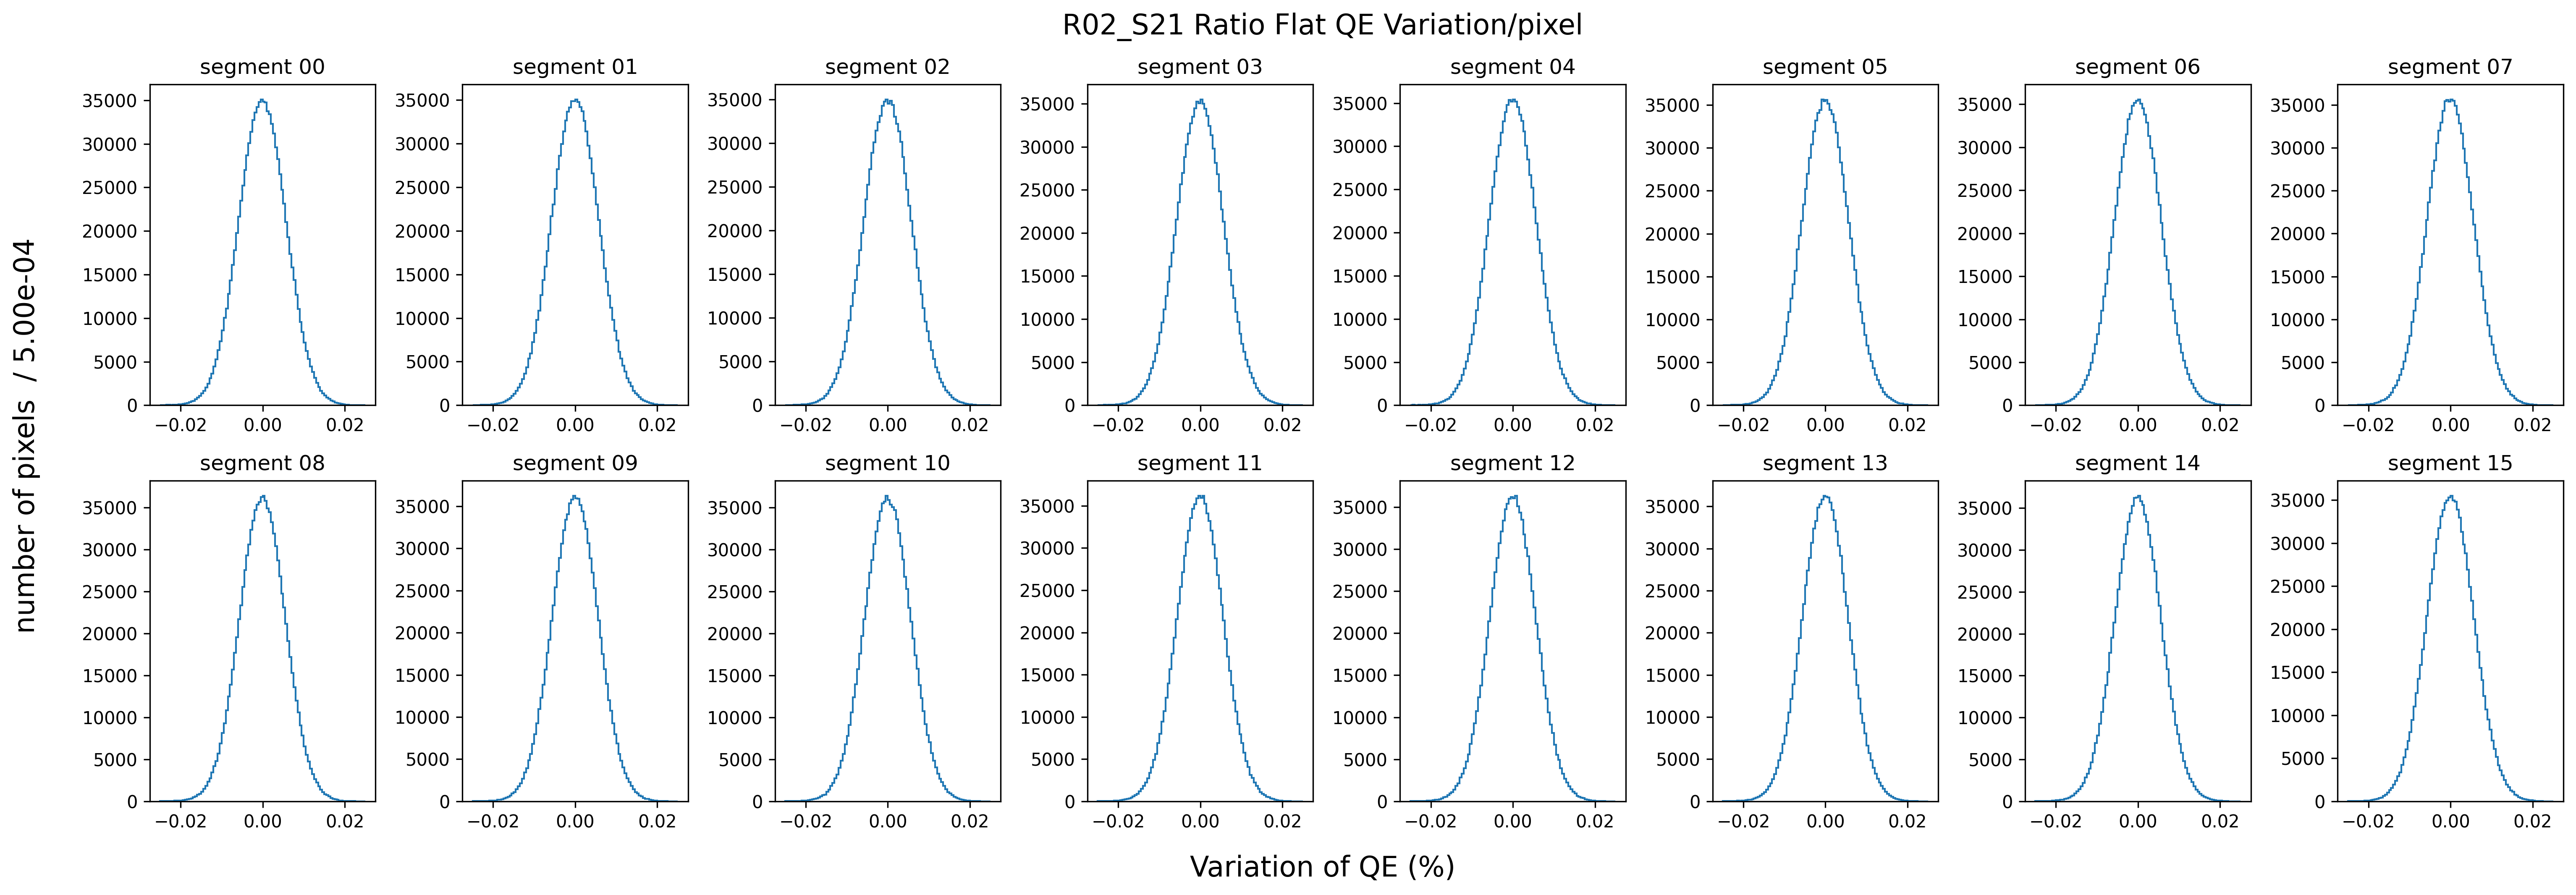

In [10]:
fig, axs = plt.subplots(2, 8, figsize=(20,7),dpi=300) 
rows = 2    
columns = 8 
axs = axs.ravel()

fig.suptitle('R02_S21 Ratio Flat QE Variation/pixel', fontsize=16)
fig.text(0.5, 0.0, "Variation of QE (%)", ha='center', fontsize=16)
fig.text(-0.02, 0.5, "number of pixels  / %.2e" % width, va='center', rotation='vertical', fontsize=16)

for i in range(16):
    x = (normedimg_arr[i] - red_arr[i]) / red_arr[i]

    axs[i].hist(x.flat, bins=bins, histtype='step')
    
    if i > 9:
        axs[i].set_title("segment " + str(i))
    else:
        axs[i].set_title("segment 0" + str(i))
    """
    if i >= 0 and i <= 7:
        axs[i].set_xticks([])
    if i > 0 and i <= 7 or i > 8:
        axs[i].set_yticks([])
    """
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Text(0.75, 0.77, 'std = 0.0262')

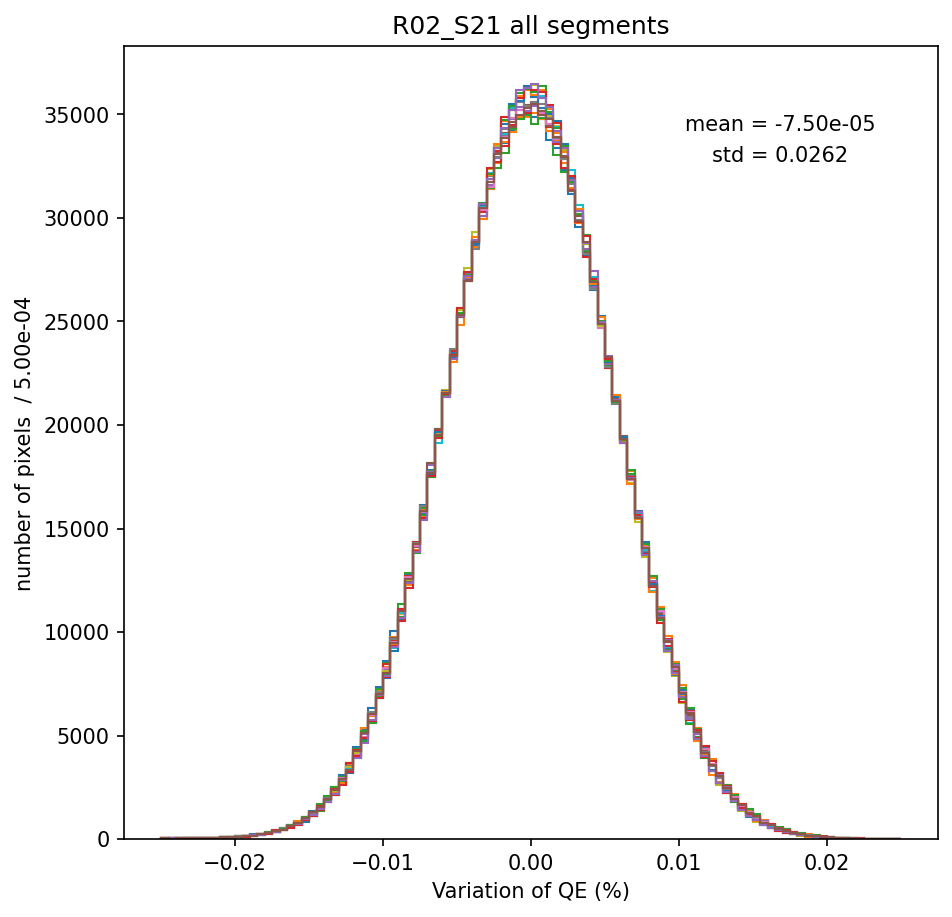

In [11]:
fig, axs = pylab.subplots(figsize=(7,7),dpi=150)

# which object/variable has the QE data for each pixel?
mean = 0
std = 0
for i in range(16):
    x = (normedimg_arr[i] - red_arr[i]) / red_arr[i]   

    pylab.hist(x.flat, bins=bins, histtype='step')          
    pylab.xlabel("Variation of QE (%)")         
    pylab.ylabel("number of pixels  / %.2e" % width)
    pylab.title('R02_S21 all segments')
    mean += x.mean()
    std += x.std()

mean = mean.mean()
std = std.mean()

fig.text(0.75, 0.8, "mean = %.2e" % x.mean(), ha='center', fontsize=10)
fig.text(0.75, 0.77, "std = " + str(round(x.std(),4)), ha ='center', fontsize=10)



In [16]:
x.min(), x.max(), x.mean(), x.std()
# plot mean and std on plot
x.shape, x.size
# how the array is split up, total number of entries in the array

((2000, 509), 1018000)

In [14]:
x
# don't need to loop over all values ... python stinks at loops, python makes it easy to get started but when you run things it makes it do more work for every step of the loop
# x passed in 2000 1D arrays (one for each row of amp), x.flat gets rid of rows shows data from whole amp
# 35,000 should be close to total num pixels
# fractional difference, difference expressed in terms of a value (red here) ... shift center of plot to zero, then change width plot to a fraction


# looking at one amp, list of lists, value at each pixel by row
# 2^10 = 1024
# float: 32 bytes , count from -2bil to +2bil for ints but we have floats
# use a different scheme for floating point nums to represent ints and exponent .... i.e. first 24 is for -1.0415187 and last 8 bytes is for e-01
# bit: 1 or 0, byte = 8 bits, rep all nums up to 256 (2^8)

# this array of data being represented using 32bit floats, give ~5digits of precision, tells us range of data we can represent, higher dtype = more space on compu

array([[-0.100609  , -0.11499091, -0.11348487, ..., -0.08644027,
        -0.0869093 , -0.09027541],
       [-0.04355966, -0.04864962, -0.05909954, ..., -0.04460372,
        -0.04042539, -0.05313446],
       [-0.04556119, -0.03385196, -0.04142286, ..., -0.01970709,
        -0.02224685, -0.02322512],
       ...,
       [ 0.01014252,  0.00058746,  0.00445151, ..., -0.0087492 ,
         0.00314949,  0.00565795],
       [ 0.00248034, -0.00420435, -0.00034192, ...,  0.00043197,
        -0.00163996, -0.0044568 ],
       [-0.00389595,  0.00555952,  0.00722252, ..., -0.00591234,
        -0.01221149, -0.01227194]], dtype=float32)